*This notebook was created by [Sergey Tomin](http://www.xfel.eu/organization/staff/tomin_sergey/) for Workshop: [Designing future X-ray FELs](http://www.xrayfels.co.uk/). Source and license info is on [GitHub](https://github.com/iagapov/ocelot/tree/dev/docs). August 2016.*

# Tutorial N2.  Tracking.

As an example, we will use lattice file (converted to Ocelot format) of the European XFEL Injector. 

##### This example will cover the following topics:
- calculation of the linear optics for the European XFEL Injector.
- Tracking of the particles in first and second order approximation without collective effects.

#### Coordiantes
Coordinates in Ocelot are following:
$$ \left (x, \quad x' = \frac{p_x}{p_0} \right), \qquad \left (y, \quad y' = \frac{p_y}{p_0} \right), \qquad \left (\Delta s = c\tau, \quad p = \frac{\Delta E}{p_0 c} \right)$$

#### Requirements 
* injector_lattice.py - input file, the Injector lattice.
* beam_130MeV.ast    - input file, initial beam distribution in [ASTRA](http://www.desy.de/~mpyflo/) format.

In [1]:
# the output of plotting commands is displayed inline within frontends, 
# directly below the code cell that produced it
%matplotlib inline

# this python library provides generic shallow (copy) and deep copy (deepcopy) operations 
from copy import deepcopy

# import from Ocelot main modules and functions
from ocelot import *

# import from Ocelot graphical modules
from ocelot.gui.accelerator import *

# import injector lattice
from ocelot.test.workshop.injector_lattice import *

initializing ocelot...


If you want to see injector_lattice.py file you can run following command (lattice file is very large):
```
$ %load injector_lattice.py
```
The variable *cell* contains all the elements of the lattice in right order.

And again Ocelot will work with class MagneticLattice instead of simple sequence of element. So we have to run following command. 

In [2]:
lat = MagneticLattice(cell, stop=None)

## 1. Design optics calculation of the European XFEL Injector
#### *Remark*
*For convenience reasons, we define optical functions starting at the gun by backtracking of the optical functions derived from ASTRA (or similar space charge code) at 130 MeV at the entrance to the first quadrupole. The optical functions we thus obtain have obviously nothing to do with the actual beam envelope form the gun to the 130 MeV point.*

Because we work with linear accelerator we have to define initial energy and initial twiss paramters in order to get 
correct twiss functions along the Injector. 

In [3]:
# initialization of Twiss object
tws0 = Twiss()
# defining initial twiss parameters
tws0.beta_x = 29.171
tws0.beta_y = 29.171
tws0.alpha_x = 10.955
tws0.alpha_y = 10.955
# defining initial electron energy in GeV
tws0.E = 0.005 

# calculate optical functions with initial twiss parameters
tws = twiss(lat, tws0, nPoints=None)

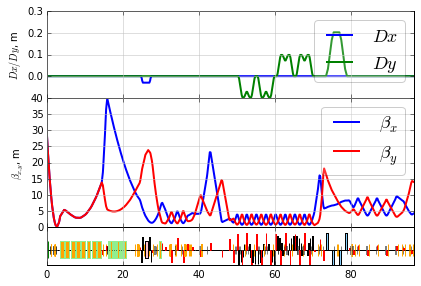

In [4]:
# ploting twiss paramentrs.
plot_opt_func(lat, tws, top_plot=["Dx", "Dy"], fig_name="i1", legend=False)
plt.show()

## 2. Tracking in first and second order approximation without any collective effects 

### Remark
*Because of the reasons mentioned above, we start the beam tracking from the first quadrupole after RF cavities.*

### Loading of beam distribution
In order to perform tracking we have to have beam distribution. We will load beam distribution from a ASTRA file ('beam_distrib.ast'). And we convert the Astra beam distribution to Ocelot format - ParticleArray. ParticleArray is designed for tracking.
In order to work with converters we have to import specific module from ocelot.adaptors
> from ocelot.adaptors.astra2ocelot import *

After importing **ocelot.adaptors.astra2ocelot** we can use converter astraBeam2particleArray() to load and convert.
As you will see beam distribution consists of 200 000 particles (**that is why loading can take a few second**), charge 250 pC, initial energy is about 6.5 MeV.

**ParticleArray** is a class which includes several parameters and methods. 
* ParticleArray.particles is a 1D numpy array with coordinates of particles in 
$$ParticleArray.particles = [\vec{x_0}, \vec{x_1}, ..., \vec{x_n}], $$ where $$\vec{x_n} = (x_n, x_n', y_n, y_n', \tau_n, p_n)$$
* ParticleArray.s is the longitudinal coordinate of the reference particle in [m]. 
* ParticleArray.E is the energy of the reference particle in [GeV]. 
* ParticleArray.q_array - is a 1D numpy array of the charges each (macro) particles in [C]

In [5]:
from ocelot.adaptors.astra2ocelot import *

#p_array_init = astraBeam2particleArray(filename='beam_130MeV.ast')
p_array_init = astraBeam2particleArray(filename='beam_130MeV_off_crest.ast')

('Astra to Ocelot: charge = ', 2.5000000000000012e-10)
('Astra to Ocelot: particles number = ', 200000)
('Astra to Ocelot: energy = ', 0.13441090135293832)


('Astra to Ocelot: s pos = ', 23.544699999999999)


### Selection of the tracking order and lattice for the tracking.

MagneticLattice(sequence, start=None, stop=None, method=MethodTM()) have wollowing arguments:     
* sequence - list of the elements,
* start - first element of the lattice. If None, then lattice starts from the first element of the sequence,
* stop - last element of the lattice. If None, then lattice stops by the last element of the sequence,
* method=MethodTM() - method of the tracking. MethodTM() class assigns transfer map to every element. By default all elements are assigned first order transfer map - TransferMap. One can create one's own map, but there are following predefined maps:
    - TransferMap - first order matrices. 
    - SecondTM - 2nd order matrices.
    - KickTM - kick applyed.
    - RungeKuttaTM - Runge-Kutta integrator is applyed, but required 3D magnetic field function element.mag_field = lambda x, y, z: (Bx, By, Bz) (see example ocelot/demos/ebeam/tune_shift.py)

In [6]:
# initialization of tracking method
method = MethodTM()

# for second order tracking we have to choose SecondTM 
method.global_method = SecondTM

# for first order tracking uncomment next line
# method.global_method = TransferMap

# we will start simulation from the first quadrupole (QI.46.I1) after RF section.
# you can change stop element (and the start element, as well) 
# START_73_I1 - marker before Dog leg
# START_96_I1 - marker before Bunch Compresion
lat_t = MagneticLattice(cell, start=QI_46_I1, stop=None, method=method)

## Tracking
for tracking we have to define following objects:
* **Navigator** defines step (dz) of tracking and which, if it exists, physical process will be applied at each step.
In order to add collective effects (Space charge, CSR or wake) method add_physics_proc() must be run.

    - **Method:**
        * Navigator.add_physics_proc(physics_proc, elem1, elem2)
            - physics_proc - physics process, can be CSR, SpaceCharge or Wake,
            - elem1 and elem2 - first and last elements between which the physics process will be applied.
    
* **track(MagneticLatice, ParticleArray, Navigator)** - the function performs tracking through the lattice [lat] of the particles [p_array]. This function also calculate twiss parameters of the beam distribution on each tracking step. 

In [7]:
navi = Navigator(lat_t)
p_array = deepcopy(p_array_init)
tws_track, p_array = track(lat_t, p_array, navi)

z = 0.2 / 73.0594010008 : applied: 

z = 0.305 / 73.0594010008 : applied: 

z = 0.5225 / 73.0594010008 : applied: 

z = 0.6185 / 73.0594010008 : applied: 

z = 0.7362 / 73.0594010008 : applied: 

z = 0.8785 / 73.0594010008 : applied: 

z = 1.0785 / 73.0594010008 : applied: 

z = 1.1785 / 73.0594010008 : applied: 

z = 1.2294998582 / 73.0594010008 : applied: 

z = 1.42983014173 / 73.0594010008 : applied: 

z = 1.53032685823 / 73.0594010008 : applied: 

z = 1.73065714176 / 73.0594010008 : applied: 

z = 1.82290699996 / 73.0594010008 : applied: 

z = 1.91890699996 / 73.0594010008 : applied: 

z = 2.19065699996 / 73.0594010008 : applied: 

z = 2.38465699996 / 73.0594010008 : applied: 

z = 3.12465699996 / 73.0594010008 : applied: 

z = 3.31865699996 / 73.0594010008 : applied: 

z = 3.43865685816 / 73.0594010008 : applied: 

z = 3.63898714169 / 73.0594010008 : applied: 

z = 3.73948485819 / 73.0594010008 : applied: 

z = 3.93981514172 / 73.0594010008 : applied: 

z = 3.99081499992 / 73.0594010008 : applied: 

z = 4.09081499992 / 73.0594010008 : applied: 

z = 4.29081499992 / 73.0594010008 : applied: 

z = 4.49930499992 / 73.0594010008 : applied: 

z = 4.69930499992 / 73.0594010008 : applied: 

z = 4.79930499992 / 73.0594010008 : applied: 

z = 5.10230499992 / 73.0594010008 : applied: 

z = 5.20230499992 / 73.0594010008 : applied: 

z = 5.39980499992 / 73.0594010008 : applied: 

z = 5.49580499992 / 73.0594010008 : applied: 

z = 5.60230499992 / 73.0594010008 : applied: 

z = 5.80230499992 / 73.0594010008 : applied: 

z = 5.87230499992 / 73.0594010008 : applied: 

z = 6.57230499992 / 73.0594010008 : applied: 

z = 6.64230499992 / 73.0594010008 : applied: 

z = 6.84230499992 / 73.0594010008 : applied: 

z = 7.59430499992 / 73.0594010008 : applied: 

z = 7.79430499992 / 73.0594010008 : applied: 

z = 8.53430499992 / 73.0594010008 : applied: 

z = 8.56930499992 / 73.0594010008 : applied: 

z = 8.74430499992 / 73.0594010008 : applied: 

z = 8.84430499992 / 73.0594010008 : applied: 

z = 8.99430499992 / 73.0594010008 : applied: 

z = 9.14430499992 / 73.0594010008 : applied: 

z = 9.34430499992 / 73.0594010008 : applied: 

z = 10.1193049999 / 73.0594010008 : applied: 

z = 10.2943049999 / 73.0594010008 : applied: 

z = 10.3943049999 / 73.0594010008 : applied: 

z = 10.5443049999 / 73.0594010008 : applied: 

z = 10.6943049999 / 73.0594010008 : applied: 

z = 10.8943049999 / 73.0594010008 : applied: 

z = 11.6693049999 / 73.0594010008 : applied: 

z = 11.9443049999 / 73.0594010008 : applied: 

z = 12.0443049999 / 73.0594010008 : applied: 

z = 12.2443049999 / 73.0594010008 : applied: 

z = 12.4443049999 / 73.0594010008 : applied: 

z = 12.6643049999 / 73.0594010008 : applied: 

z = 13.0443049999 / 73.0594010008 : applied: 

z = 13.3443049999 / 73.0594010008 : applied: 

z = 13.5443049999 / 73.0594010008 : applied: 

z = 13.8260049999 / 73.0594010008 : applied: 

z = 14.1903049999 / 73.0594010008 : applied: 

z = 14.3403049999 / 73.0594010008 : applied: 

z = 14.5943049999 / 73.0594010008 : applied: 

z = 14.7943049999 / 73.0594010008 : applied: 

z = 15.3443049999 / 73.0594010008 : applied: 

z = 16.5843049999 / 73.0594010008 : applied: 

z = 16.6843049999 / 73.0594010008 : applied: 

z = 16.7843049999 / 73.0594010008 : applied: 

z = 16.9843049999 / 73.0594010008 : applied: 

z = 17.1343049999 / 73.0594010008 : applied: 

z = 18.5843049999 / 73.0594010008 : applied: 

z = 18.6843049999 / 73.0594010008 : applied: 

z = 19.3343049999 / 73.0594010008 : applied: 

z = 19.5343049999 / 73.0594010008 : applied: 

z = 22.4343049999 / 73.0594010008 : applied: 

z = 22.6343049999 / 73.0594010008 : applied: 

z = 24.4343049999 / 73.0594010008 : applied: 

z = 24.6343049999 / 73.0594010008 : applied: 

z = 25.3343049999 / 73.0594010008 : applied: 

z = 25.5343049999 / 73.0594010008 : applied: 

z = 25.7343049999 / 73.0594010008 : applied: 

z = 25.9343049999 / 73.0594010008 : applied: 

z = 26.0343049999 / 73.0594010008 : applied: 

z = 26.2343049999 / 73.0594010008 : applied: 

z = 26.3343049999 / 73.0594010008 : applied: 

z = 26.4343049999 / 73.0594010008 : applied: 

z = 26.6343049999 / 73.0594010008 : applied: 

z = 26.835531668 / 73.0594010008 : applied: 

z = 27.0356343319 / 73.0594010008 : applied: 

z = 27.170634 / 73.0594010008 : applied: 

z = 27.270634 / 73.0594010008 : applied: 

z = 27.516116 / 73.0594010008 : applied: 

z = 27.616116 / 73.0594010008 : applied: 

z = 27.716116 / 73.0594010008 : applied: 

z = 27.916116 / 73.0594010008 : applied: 

z = 28.016116 / 73.0594010008 : applied: 

z = 28.116116 / 73.0594010008 : applied: 

z = 28.2570984195 / 73.0594010008 : applied: 

z = 28.4571135806 / 73.0594010008 : applied: 

z = 28.6157220001 / 73.0594010008 : applied: 

z = 28.7482220001 / 73.0594010008 : applied: 

z = 28.8482220001 / 73.0594010008 : applied: 

z = 28.9657220001 / 73.0594010008 : applied: 

z = 29.1657220001 / 73.0594010008 : applied: 

z = 29.3007220001 / 73.0594010008 : applied: 

z = 29.4007220001 / 73.0594010008 : applied: 

z = 29.6743294195 / 73.0594010008 : applied: 

z = 29.8743445806 / 73.0594010008 : applied: 

z = 30.0153270001 / 73.0594010008 : applied: 

z = 30.1153270001 / 73.0594010008 : applied: 

z = 30.2153270001 / 73.0594010008 : applied: 

z = 30.4153270001 / 73.0594010008 : applied: 

z = 30.5153270001 / 73.0594010008 : applied: 

z = 30.6153270001 / 73.0594010008 : applied: 

z = 30.9458090001 / 73.0594010008 : applied: 

z = 31.0958086682 / 73.0594010008 : applied: 

z = 31.2959113321 / 73.0594010008 : applied: 

z = 31.4971380002 / 73.0594010008 : applied: 

z = 31.6971380002 / 73.0594010008 : applied: 

z = 31.8983656683 / 73.0594010008 : applied: 

z = 32.0984683321 / 73.0594010008 : applied: 

z = 32.2334680002 / 73.0594010008 : applied: 

z = 32.3334680002 / 73.0594010008 : applied: 

z = 32.5789500002 / 73.0594010008 : applied: 

z = 32.6789500002 / 73.0594010008 : applied: 

z = 32.7789500002 / 73.0594010008 : applied: 

z = 32.9789500002 / 73.0594010008 : applied: 

z = 33.0789500002 / 73.0594010008 : applied: 

z = 33.1789500002 / 73.0594010008 : applied: 

z = 33.3199314197 / 73.0594010008 : applied: 

z = 33.5199465808 / 73.0594010008 : applied: 

z = 33.6785550003 / 73.0594010008 : applied: 

z = 33.8110550003 / 73.0594010008 : applied: 

z = 33.9110550003 / 73.0594010008 : applied: 

z = 34.0285550003 / 73.0594010008 : applied: 

z = 34.2285550003 / 73.0594010008 : applied: 

z = 34.3635550003 / 73.0594010008 : applied: 

z = 34.4635550003 / 73.0594010008 : applied: 

z = 34.7371634198 / 73.0594010008 : applied: 

z = 34.9371785809 / 73.0594010008 : applied: 

z = 35.0781610004 / 73.0594010008 : applied: 

z = 35.1781610004 / 73.0594010008 : applied: 

z = 35.2781610004 / 73.0594010008 : applied: 

z = 35.4781610004 / 73.0594010008 : applied: 

z = 35.5781610004 / 73.0594010008 : applied: 

z = 35.6781610004 / 73.0594010008 : applied: 

z = 36.0086420004 / 73.0594010008 : applied: 

z = 36.1586426685 / 73.0594010008 : applied: 

z = 36.3587453323 / 73.0594010008 : applied: 

z = 36.5599720004 / 73.0594010008 : applied: 

z = 36.7599720004 / 73.0594010008 : applied: 

z = 36.9611986685 / 73.0594010008 : applied: 

z = 37.1613013324 / 73.0594010008 : applied: 

z = 37.1613020005 / 73.0594010008 : applied: 

z = 37.2963020005 / 73.0594010008 : applied: 

z = 37.3963020005 / 73.0594010008 : applied: 

z = 37.6417830005 / 73.0594010008 : applied: 

z = 37.7417830005 / 73.0594010008 : applied: 

z = 37.8417830005 / 73.0594010008 : applied: 

z = 38.0417830005 / 73.0594010008 : applied: 

z = 38.1417830005 / 73.0594010008 : applied: 

z = 38.2417830005 / 73.0594010008 : applied: 

z = 38.38276542 / 73.0594010008 : applied: 

z = 38.5827805811 / 73.0594010008 : applied: 

z = 38.7413890006 / 73.0594010008 : applied: 

z = 38.8738890006 / 73.0594010008 : applied: 

z = 38.9738890006 / 73.0594010008 : applied: 

z = 39.0913890006 / 73.0594010008 : applied: 

z = 39.2913890006 / 73.0594010008 : applied: 

z = 39.4263890006 / 73.0594010008 : applied: 

z = 39.5263890006 / 73.0594010008 : applied: 

z = 39.7999974201 / 73.0594010008 : applied: 

z = 40.0000125811 / 73.0594010008 : applied: 

z = 40.1409940006 / 73.0594010008 : applied: 

z = 40.2409940006 / 73.0594010008 : applied: 

z = 40.3409940006 / 73.0594010008 : applied: 

z = 40.5409940006 / 73.0594010008 : applied: 

z = 40.6409940006 / 73.0594010008 : applied: 

z = 40.7409940006 / 73.0594010008 : applied: 

z = 41.0714760006 / 73.0594010008 : applied: 

z = 41.2214766687 / 73.0594010008 : applied: 

z = 41.4215793326 / 73.0594010008 : applied: 

z = 41.6228060007 / 73.0594010008 : applied: 

z = 41.8228060007 / 73.0594010008 : applied: 

z = 42.0240326688 / 73.0594010008 : applied: 

z = 42.2241353326 / 73.0594010008 : applied: 

z = 42.3591350007 / 73.0594010008 : applied: 

z = 42.4591350007 / 73.0594010008 : applied: 

z = 42.7046170007 / 73.0594010008 : applied: 

z = 42.8046170007 / 73.0594010008 : applied: 

z = 42.9046170007 / 73.0594010008 : applied: 

z = 43.1046170007 / 73.0594010008 : applied: 

z = 43.2046170007 / 73.0594010008 : applied: 

z = 43.3046170007 / 73.0594010008 : applied: 

z = 43.4455984202 / 73.0594010008 : applied: 

z = 43.6456135813 / 73.0594010008 : applied: 

z = 43.6456140008 / 73.0594010008 : applied: 

z = 43.8042220008 / 73.0594010008 : applied: 

z = 43.9367220008 / 73.0594010008 : applied: 

z = 44.0367220008 / 73.0594010008 : applied: 

z = 44.1542220008 / 73.0594010008 : applied: 

z = 44.3542220008 / 73.0594010008 : applied: 

z = 44.8628304203 / 73.0594010008 : applied: 

z = 45.0628455814 / 73.0594010008 : applied: 

z = 45.2038280009 / 73.0594010008 : applied: 

z = 45.3038280009 / 73.0594010008 : applied: 

z = 45.4038280009 / 73.0594010008 : applied: 

z = 45.6038280009 / 73.0594010008 : applied: 

z = 45.7038280009 / 73.0594010008 : applied: 

z = 45.8038280009 / 73.0594010008 : applied: 

z = 45.9018100009 / 73.0594010008 : applied: 

z = 46.0018100009 / 73.0594010008 : applied: 

z = 46.1343100009 / 73.0594010008 : applied: 

z = 46.284309669 / 73.0594010008 : applied: 

z = 46.4844123328 / 73.0594010008 : applied: 

z = 46.6856390009 / 73.0594010008 : applied: 

z = 46.8856390009 / 73.0594010008 : applied: 

z = 47.7857690009 / 73.0594010008 : applied: 

z = 47.9857690009 / 73.0594010008 : applied: 

z = 48.0857690009 / 73.0594010008 : applied: 

z = 48.1957690009 / 73.0594010008 : applied: 

z = 48.3957690009 / 73.0594010008 : applied: 

z = 48.6957690009 / 73.0594010008 : applied: 

z = 48.7917690009 / 73.0594010008 : applied: 

z = 48.9957690009 / 73.0594010008 : applied: 

z = 49.0957690009 / 73.0594010008 : applied: 

z = 49.2057690009 / 73.0594010008 : applied: 

z = 49.4057690009 / 73.0594010008 : applied: 

z = 49.8057690009 / 73.0594010008 : applied: 

z = 49.9057694404 / 73.0594010008 : applied: 

z = 50.4072405614 / 73.0594010008 : applied: 

z = 51.4161134405 / 73.0594010008 : applied: 

z = 51.9175845614 / 73.0594010008 : applied: 

z = 51.9175850009 / 73.0594010008 : applied: 

z = 52.7825850009 / 73.0594010008 : applied: 

z = 53.0925850009 / 73.0594010008 : applied: 

z = 53.4175854404 / 73.0594010008 : applied: 

z = 53.9190565613 / 73.0594010008 : applied: 

z = 54.9279294404 / 73.0594010008 : applied: 

z = 55.4294005613 / 73.0594010008 : applied: 

z = 55.4294010008 / 73.0594010008 : applied: 

z = 55.5294010008 / 73.0594010008 : applied: 

z = 55.9394010008 / 73.0594010008 : applied: 

z = 56.1394010008 / 73.0594010008 : applied: 

z = 56.2494010008 / 73.0594010008 : applied: 

z = 56.3494010008 / 73.0594010008 : applied: 

z = 56.5994010008 / 73.0594010008 : applied: 

z = 56.6954010008 / 73.0594010008 : applied: 

z = 56.8394010008 / 73.0594010008 : applied: 

z = 56.9394010008 / 73.0594010008 : applied: 

z = 57.0494010008 / 73.0594010008 : applied: 

z = 57.2494010008 / 73.0594010008 : applied: 

z = 57.4494010008 / 73.0594010008 : applied: 

z = 58.0094010008 / 73.0594010008 : applied: 

z = 58.1094010008 / 73.0594010008 : applied: 

z = 58.2194010008 / 73.0594010008 : applied: 

z = 58.4194010008 / 73.0594010008 : applied: 

z = 58.6194010008 / 73.0594010008 : applied: 

z = 60.5094010008 / 73.0594010008 : applied: 

z = 60.6094010008 / 73.0594010008 : applied: 

z = 60.7194010008 / 73.0594010008 : applied: 

z = 60.9194010008 / 73.0594010008 : applied: 

z = 61.1194010008 / 73.0594010008 : applied: 

z = 63.0094010008 / 73.0594010008 : applied: 

z = 63.1094010008 / 73.0594010008 : applied: 

z = 63.2194010008 / 73.0594010008 : applied: 

z = 63.4194010008 / 73.0594010008 : applied: 

z = 63.6194010008 / 73.0594010008 : applied: 

z = 65.5094010008 / 73.0594010008 : applied: 

z = 65.6094010008 / 73.0594010008 : applied: 

z = 65.7194010008 / 73.0594010008 : applied: 

z = 65.9194010008 / 73.0594010008 : applied: 

z = 66.1194010008 / 73.0594010008 : applied: 

z = 68.1594010008 / 73.0594010008 : applied: 

z = 68.2594010008 / 73.0594010008 : applied: 

z = 68.3694010008 / 73.0594010008 : applied: 

z = 68.5694010008 / 73.0594010008 : applied: 

z = 68.7694010008 / 73.0594010008 : applied: 

z = 69.8936010008 / 73.0594010008 : applied: 

z = 70.0344010008 / 73.0594010008 : applied: 

z = 70.1344010008 / 73.0594010008 : applied: 

z = 70.2444010008 / 73.0594010008 : applied: 

z = 70.4444010008 / 73.0594010008 : applied: 

z = 70.6029010008 / 73.0594010008 : applied: 

z = 71.6942210008 / 73.0594010008 : applied: 

z = 72.0432510008 / 73.0594010008 : applied: 

z = 72.1344010008 / 73.0594010008 : applied: 

z = 72.2344010008 / 73.0594010008 : applied: 

z = 72.3444010008 / 73.0594010008 : applied: 

z = 72.5444010008 / 73.0594010008 : applied: 

z = 72.7072010008 / 73.0594010008 : applied: 

z = 73.0594010008 / 73.0594010008 : applied: 

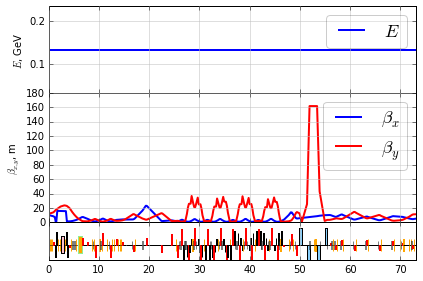

In [8]:
# you can change top_plot argument, for example top_plot=["alpha_x", "alpha_y"]
plot_opt_func(lat_t, tws_track, top_plot=["E"], fig_name=0, legend=False)
plt.show()

('Imax = ', 115.73464823829795)


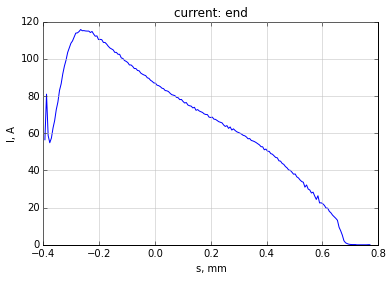

In [9]:
bins_start, hist_start = get_current(p_array, charge=p_array.q_array[0], num_bins=200)

plt.figure(4)
plt.title("current: end")
plt.plot(bins_start*1000, hist_start)
plt.xlabel("s, mm")
plt.ylabel("I, A")
plt.grid(True)
plt.show()

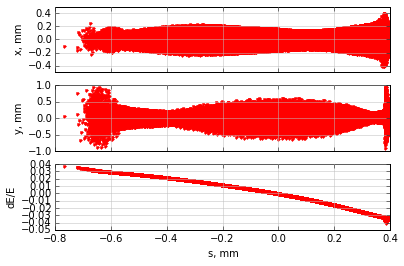

In [10]:
tau = np.array([p.tau for p in p_array])
dp = np.array([p.p for p in p_array])
x = np.array([p.x for p in p_array])
y = np.array([p.y for p in p_array])

ax1 = plt.subplot(311)
ax1.plot(-tau*1000, x*1000, 'r.')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel("x, mm")
plt.grid(True)

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(-tau*1000, y*1000, 'r.')
plt.setp(ax2.get_xticklabels(), visible=False)
plt.ylabel("y, mm")
plt.grid(True)

ax3 = plt.subplot(313, sharex=ax1)
ax3.plot(-tau*1000, dp, 'r.')
plt.ylabel("dE/E")
plt.xlabel("s, mm")
plt.grid(True)
plt.show()